# Práctica: Clustering

* **Alumno 1**: Carlos Jiménez Martín - 160190
* **Alumno 2**: Enrique Gonzalez Rodríguez - 160329


In [0]:
import numpy as np
from sklearn.base import BaseEstimator
from abc import abstractmethod

class Classifier(BaseEstimator):

    @abstractmethod
    def fit(self, X, y):
        pass
      
    @abstractmethod
    def predict(self, X):
        pass

class KMeans_Cluster(Classifier):
    def __init__(self, k):
        """ Class contructor """
        self.clusters = []
        self.centroids = []
        self.k = k
        pass

    def fit(self, X, y):
        """Fits the classifier
        X: numpy matrix, each row is an element, each column is a feature
        return Classifier object"""

        # Initializes variables
        X_clusters = np.empty(len(X), dtype=int)

        for i in range(self.k):
          self.centroids.append(X[i])
          self.clusters.append([])
          # Marks cluster where the element has been inserted
          X_clusters[i] = i

        new_centroids = []
        convergence_cond = False;
        while convergence_cond == False:
          for i in range(len(X)):
            # Calculates the distance to all the clusters
            cluster_dist = np.array([np.linalg.norm(self.centroids[c]-X[i]) for c in range(k)])
            # Selects the nearest cluster to the element
            cluster = np.argmin(cluster_dist)
            # Inserts the element to the selected cluster
            self.clusters[cluster].append(X[i])
            # Marks cluster in which the element has been inserted
            X_clusters[i] = cluster
          
          new_centroids = [np.mean(c, axis=0) for c in self.clusters]

          if np.array_equal(self.centroids, new_centroids) == True:
            convergence_cond = True
          else:
            self.centroids = new_centroids 
            self.clusters = []
            for i in range(self.k):
              self.clusters.append([])

        return X_clusters

    def decision_function(self, X):
        """Estima el grado de pertenencia de cada dato a todas las clases
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas.
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        assert self.centroids is not None, "Error: The classifier needs to be fitted. Please call fit(X, y) method."
        assert X.ndim == 2 and X.shape[1] == len(self.centroids[0])

        # Calcula y devuelve la distancia a cada centroide
        distances = []
        for i in range(len(X)):
          distances.append([c - X[i] for c in self.centroids])
        
        return np.linalg.norm(distances, axis=2)
        
    def predict(self, X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmin(self.decision_function(X), axis=1)

In [0]:
class Sequential_Cluster(Classifier):
    def __init__(self, q, theta):
        """ Class contructor """
        self.clusters = None
        self.q = q
        self.theta = theta
        self.centroids = None
        pass

    def fit(self, X, y):
        """Fits the classifier
        X: numpy matrix, each row is an element, each column is a feature
        return Classifier object"""
        
        # Initializes variables
        X_clusters = np.empty(len(X), dtype=int)

        # Inserts the first element into the initial cluster
        self.clusters = [[X[0]]]
        X_clusters[0] = 0

        # Iterates data for selecting their asociated cluster
        clusters_count = 1

        for i in range(1, len(X)):
          # Inserts the element into the selected cluster
          cluster_dist  = np.array([np.linalg.norm(np.mean(c, axis=0) - X[i]) for c in self.clusters])
          
          if clusters_count<self.q and len(np.where(cluster_dist > self.theta)[0])==clusters_count:
            self.clusters.append([X[i]])
            # Marks cluster in which the element has been inserted
            X_clusters[i] = clusters_count
            clusters_count += 1

          else:
            # Inserts the element into the selected cluster 
            cluster = np.argmin(cluster_dist)
            self.clusters[cluster].append(X[i])
            # Marks cluster in which the element has been inserted
            X_clusters[i] = cluster

        self.centroids = np.array([np.mean(c, axis=0) for c in self.clusters])

        return X_clusters

    def decision_function(self, X):
        """Estima el grado de pertenencia de cada dato a todas las clases
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas.
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        assert self.centroids is not None, "Error: The classifier needs to be fitted. Please call fit(X, y) method."
        assert X.ndim == 2 and X.shape[1] == len(self.centroids[0])

        # Calcula y devuelve la distancia a cada centroide
        distances = []
        for i in range(len(X)):
          distances.append([c - X[i] for c in self.centroids])
        
        return np.linalg.norm(distances, axis=2)
        
    def predict(self, X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmin(self.decision_function(X), axis=1)


In [0]:
from sklearn.model_selection import cross_val_score
from scipy import stats

class EnsemblesKMeans(Classifier):
    def __init__(self, improvement, cv, k, limit):
        """ Class contructor """
        self.clf_list = None
        self.improvement = improvement
        self.cv = cv
        self.k = k
        self.limit = limit
        pass


    def fit(self, X, y):
        """Fits the classifier
        X: numpy matrix, each row is an element, each column is a feature
        return Classifier object"""
        clf = KMeans_Cluster(k)
        clf.fit(X, y)
        self.clf_list = [clf]
        scores_list = [cross_val_score(clf, X, y, scoring="accuracy", n_jobs=-1, cv=self.cv).mean()]
        X_train = X
        y_train = y
        l = 0;

        while scores_list[-1]<scores_list[0]+self.improvement and l<self.limit:
          pred_labels = self.clf_list[-1].predict(X_train)
          error_values_index = y_train != pred_labels
          X_train = X_train[error_values_index]
          y_train = y_train[error_values_index]
          #print(X_train)
          #print(y_train)

          if len(np.unique(y_train))==1 or len(y_train)==0:
            break

          clf = KMeans_Cluster(k)
          clf.fit(X_train, y_train)
          self.clf_list.append(clf)

          aux_scores = []
          for fit_clf in self.clf_list:
            aux_scores.append(cross_val_score(fit_clf, X, y, scoring="accuracy", n_jobs=-1, cv=self.cv).mean())
          scores_list.append(sum(aux_scores)/len(aux_scores))
          l = l + 1

        return scores_list

    def predict(self, X):
        pred_labels = np.array([])
        for clf in clf_list:
          pred_labels = np.append(pred_labels, [clf.predict(X)])

        return stats.mode(pred_labels)[0][0]

In [0]:
from sklearn.model_selection import cross_val_score
from scipy import stats

class EnsemblesSequential(Classifier):
    def __init__(self, improvement, cv, q, theta, limit):
        """ Class contructor """
        self.clf_list = None
        self.improvement = improvement
        self.cv = cv
        self.q = q
        self.theta = theta
        self.limit = limit
        pass


    def fit(self, X, y):
        """Fits the classifier
        X: numpy matrix, each row is an element, each column is a feature
        return Classifier object"""
        clf = Sequential_Cluster(self.q, self.theta)
        clf.fit(X, y)
        self.clf_list = [clf]
        scores_list = [cross_val_score(clf, X, y, scoring="accuracy", n_jobs=-1, cv=self.cv).mean()]
        X_train = X
        y_train = y
        l = 0;

        while scores_list[-1]<scores_list[0]+self.improvement and l<self.limit:
          pred_labels = self.clf_list[-1].predict(X_train)
          error_values_index = y_train != pred_labels
          X_train = X_train[error_values_index]
          y_train = y_train[error_values_index]
          #print(X_train)
          #print(y_train)

          if len(np.unique(y_train))==1 or len(y_train)==0:
            break

          clf = Sequential_Cluster(q, theta)
          clf.fit(X_train, y_train)
          self.clf_list.append(clf)

          aux_scores = []
          for fit_clf in self.clf_list:
            aux_scores.append(cross_val_score(fit_clf, X, y, scoring="accuracy", n_jobs=-1, cv=self.cv).mean())
          scores_list.append(sum(aux_scores)/len(aux_scores))
          l = l + 1

        return scores_list

    def predict(self, X):
        pred_labels = np.array([])
        for clf in clf_list:
          pred_labels = np.append(pred_labels, [clf.predict(X)])

        return stats.mode(pred_labels)[0][0]

In [0]:
import matplotlib.pyplot as plt

def chainMap(X):
    """Fits the classifier
    X: numpy matrix, each row is an element, each column is a feature
    prints the distances between elements"""

    iterations = range(len(X)-1) # Iterations number
    dist = np.array([]) # Distance array 

    # Begins with the first element to initiate the algorithim
    actual_val = X[0]
    X = np.delete(X, 0, axis=0)

    # Calculates all the distance to the final plot
    while X.shape[0] > 0:
      # Calculates the all distances to the actual element
      calculated_dist = np.linalg.norm(X - actual_val, axis=1)
      # Selects the minimun distance to the following element
      i = np.argmin(calculated_dist, axis=0)
      # Changes the actual value to the previously selected
      actual_val = X[i]
      # Appends the distance to the distance array
      dist = np.append(dist, [calculated_dist[i]], axis=0)
      X = np.delete(X, i, axis=0)

    # Plot the results
    plt.title("Minimum distances") 
    plt.xlabel("Iterations") 
    plt.ylabel("Distance")
    plt.plot(iterations, dist) 
    plt.show()
    
    
def get_compaction(X_clusters, y):
    cluster_compaction = np.empty(len(np.unique(X_clusters)), dtype=object)
        
    for cluster in range(len(np.unique(X_clusters))):
      # Gets cluster labels for each cluster
      cluster_labels = y[X_clusters==cluster]
      # Counts the total number of the labels inside the cluster
      cont_labels = {i: len(np.where(cluster_labels == i)[0]) for i in np.unique(cluster_labels)}
      # Gets the mode label by the previous accounting
      mode_label = max(cont_labels, key=cont_labels.get)
      compactation = (cont_labels[mode_label]/len(cluster_labels))*100
      # Calculates the cluster compactation from the mode label
      cluster_compaction[cluster] = {"Cluster": cluster, "Label": mode_label, 
                                     "Compactation": "{0:.2f}%".format(compactation)}

    return cluster_compaction


def evaluate(y):
    x = []
    for i in range(len(y)):
      y[i] = y[i]*100
      x.append("C"+str(i))
    # Plot the results
    plt.title("Ensembles") 
    plt.xlabel("Classifiers") 
    plt.ylabel("Accuracy")
    plt.axis([0,len(y)-1,0,100])
    plt.plot(x, y, 'bo',markersize=12) 
    plt.show()

## Iris Dataset
Carga, entrenamiento, predicción y evaluación en la base de datos de Iris:

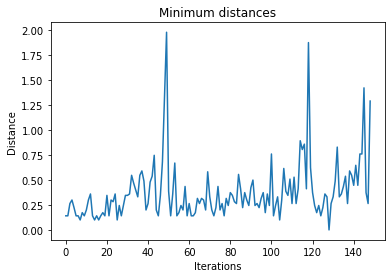

Cluster K-means
[{'Cluster': 0, 'Label': 0, 'Compactation': '100.00%'}
 {'Cluster': 1, 'Label': 1, 'Compactation': '77.05%'}
 {'Cluster': 2, 'Label': 2, 'Compactation': '92.31%'}]
[0 1 2 1 2 1 2 2 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 2 0 1 2 0 0 1 1 1 1 2 2 0 1
 2 2 0 2 0 1 2 2 1 0 1 1 1 2 2 1 2 0 1 1 1 1 0 0 1 1 1 1 2 0 0 2 1 1 0 1 2
 1 0 2 2 0 1 0 2 1 1 1 0 0 0 2 1 2 0 0 1 1 0 2 2 0 2 1 0 1 1 2 2 2 1 1 1 2
 2 0 1 0 1 1 1 0 0 2 1 2 2 1 0 0 0 0 2 1 0 1 0 1 1 1 0 1 1 1 2 0 2 1 0 1 0
 1 2]

Cluster secuencial
[{'Cluster': 0, 'Label': 0, 'Compactation': '100.00%'}
 {'Cluster': 1, 'Label': 2, 'Compactation': '76.56%'}
 {'Cluster': 2, 'Label': 1, 'Compactation': '97.22%'}]

K-Means Ensembles
[0.8200000000000001, 0.8200000000000001]


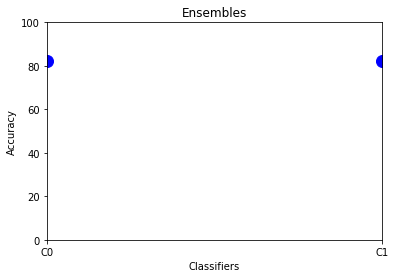


Sequential Ensembles
[0.45999999999999996, 0.45999999999999996]


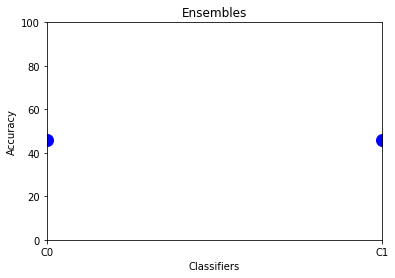

In [59]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.datasets import load_iris


# 1. Cargar los datos de la base de datos de entrenamiento
dataset = load_iris()
X = dataset.data
y = pd.factorize(dataset.target)[0]

# 2. Baraja los datos
X, y = shuffle(X, y)

# 3. Chain-Map
chainMap(X)

# 4. Entrenar y evaluar el algoritmo
print("Cluster K-means")
k = 3
clf = KMeans_Cluster(k)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))
print(clf.predict(X))

print("\nCluster secuencial")
q = 3
theta = 1.5
clf = Sequential_Cluster(q, theta)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nK-Means Ensembles")
clf = EnsemblesKMeans(5, 10, 3, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

print("\nSequential Ensembles")
clf = EnsemblesSequential(5, 10, 3, 1.5, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)



## Wine dataset
Carga, entrenamiento, predicción y evaluación en la base de datos de Wine:

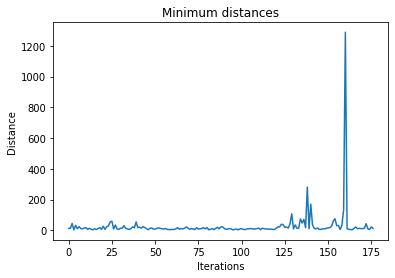

Cluster K-means
[{'Cluster': 0, 'Label': 0, 'Compactation': '100.00%'}
 {'Cluster': 1, 'Label': 1, 'Compactation': '63.27%'}
 {'Cluster': 2, 'Label': 0, 'Compactation': '55.10%'}]

Cluster secuencial
[{'Cluster': 0, 'Label': 0, 'Compactation': '100.00%'}
 {'Cluster': 1, 'Label': 1, 'Compactation': '62.63%'}
 {'Cluster': 2, 'Label': 0, 'Compactation': '58.82%'}]

Ensembles
[0.5617647058823529, 0.5617647058823529, 0.5617647058823529, 0.5617647058823529, 0.5617647058823529, 0.5617647058823528, 0.5617647058823528]


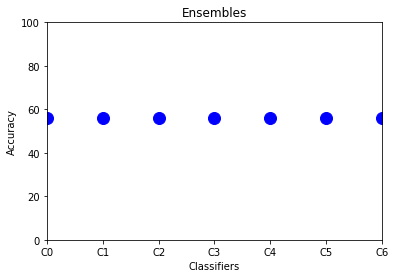


Sequential Ensembles
[0.5562091503267974, 0.5562091503267974, 0.5562091503267974, 0.5562091503267974]


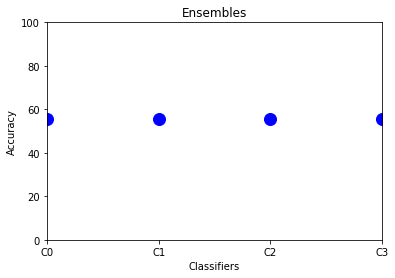

In [60]:
from sklearn.datasets import load_wine

# 1. Cargar los datos de la base de datos de entrenamiento
dataset = load_wine()
X = dataset.data
y = pd.factorize(dataset.target)[0]

# 2. Baraja los datos
X, y = shuffle(X, y)

# 3. Chain-Map
chainMap(X)

# 4. Entrenar y evaluar el algoritmo
print("Cluster K-means")
k = 3
clf = KMeans_Cluster(k)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nCluster secuencial")
q = 3
theta = 100
clf = Sequential_Cluster(q, theta)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nEnsembles")
clf = EnsemblesKMeans(5, 10, 3, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

print("\nSequential Ensembles")
clf = EnsemblesSequential(5, 10, 3, 100, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

## Breast cancer dataset
Carga, entrenamiento, predicción y evaluación en la base de datos de Breast cancer:

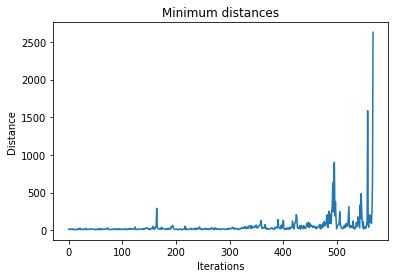

Cluster K-means
[{'Cluster': 0, 'Label': 1, 'Compactation': '81.28%'}
 {'Cluster': 1, 'Label': 0, 'Compactation': '99.24%'}]

Cluster secuencial
[{'Cluster': 0, 'Label': 1, 'Compactation': '81.28%'}
 {'Cluster': 1, 'Label': 0, 'Compactation': '99.24%'}]

Ensembles
[0.21065162907268173, 0.21065162907268173, 0.21065162907268173, 0.21065162907268173, 0.21065162907268173, 0.21065162907268173, 0.2106516290726817]


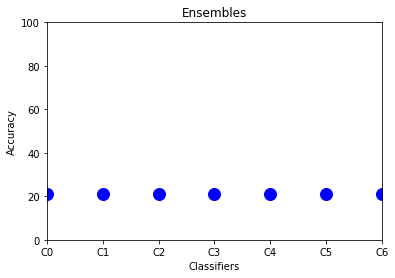


Sequential Ensembles
[0.15100250626566414, 0.15100250626566414, 0.15100250626566414, 0.15100250626566414, 0.15100250626566414, 0.15100250626566414, 0.15100250626566414]


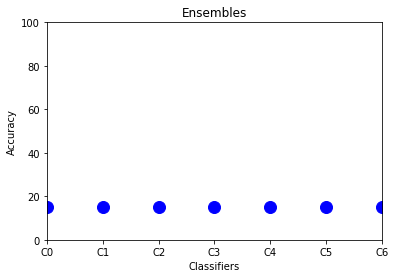

In [61]:
from sklearn.datasets import load_breast_cancer

# 1. Cargar los datos de la base de datos de entrenamiento
dataset = load_breast_cancer()
X = dataset.data
y = pd.factorize(dataset.target)[0]

# 2. Baraja los datos
X, y = shuffle(X, y)

# 3. Chain-Map
chainMap(X)

# 4. Entrenar y evaluar el algoritmo
print("Cluster K-means")
k=2
clf = KMeans_Cluster(k)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nCluster secuencial")
q = 2
theta = 800
clf = Sequential_Cluster(q, theta)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nEnsembles")
clf = EnsemblesKMeans(5, 10, 2, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

print("\nSequential Ensembles")
clf = EnsemblesSequential(5, 10, 2, 800, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

## Isolet Dataset (Isolated Letter Speech Recognition)
Carga, entrenamiento, predicción y evaluación en la base de datos de Isolet

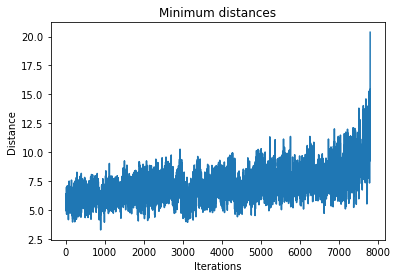

Cluster K-means
[{'Cluster': 0, 'Label': 19, 'Compactation': '39.51%'}
 {'Cluster': 1, 'Label': 7, 'Compactation': '100.00%'}
 {'Cluster': 2, 'Label': 7, 'Compactation': '61.95%'}
 {'Cluster': 3, 'Label': 22, 'Compactation': '99.35%'}
 {'Cluster': 4, 'Label': 14, 'Compactation': '48.16%'}
 {'Cluster': 5, 'Label': 24, 'Compactation': '99.66%'}
 {'Cluster': 6, 'Label': 17, 'Compactation': '93.90%'}
 {'Cluster': 7, 'Label': 0, 'Compactation': '75.23%'}
 {'Cluster': 8, 'Label': 23, 'Compactation': '98.08%'}
 {'Cluster': 9, 'Label': 4, 'Compactation': '25.16%'}
 {'Cluster': 10, 'Label': 10, 'Compactation': '47.66%'}
 {'Cluster': 11, 'Label': 5, 'Compactation': '44.97%'}
 {'Cluster': 12, 'Label': 16, 'Compactation': '91.88%'}
 {'Cluster': 13, 'Label': 12, 'Compactation': '48.03%'}
 {'Cluster': 14, 'Label': 18, 'Compactation': '53.44%'}
 {'Cluster': 15, 'Label': 2, 'Compactation': '49.28%'}
 {'Cluster': 16, 'Label': 22, 'Compactation': '83.08%'}
 {'Cluster': 17, 'Label': 4, 'Compactation': '2

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [0]:
from sklearn.datasets import fetch_openml

# 1. Cargar los datos de la base de datos de entrenamiento
X, y = fetch_openml('isolet', version=1, return_X_y=True, cache=True)
y = pd.factorize(y)[0]

# 2. Baraja los datos
X, y = shuffle(X, y)

# 3. Chain-Map
chainMap(X)

# 4. Entrenar y evaluar el algoritmo
print("Cluster K-means")
k = 26
clf = KMeans_Cluster(k)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nCluster secuencial")
q = 26
theta = 7.75
clf = Sequential_Cluster(q, theta)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nEnsembles")
clf = EnsemblesKMeans(5, 10, 26, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

print("\nSequential Ensembles")
clf = EnsemblesSequential(5, 10, 26, 7.75, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

## MNIST Database (Modified National Institute of Standards and Technology database)
MNIST es una base de datos de texto manuscrito, que se usa de forma clásica para entrenar sistemas de procesado de imágenes.

Carga, entrenamiento, predicción y evaluación en la base de datos de MNIST:


In [0]:
from sklearn.datasets import fetch_openml

# 1. Cargar los datos de la base de datos de entrenamiento
all_X, all_y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)

# 2. Baraja los datos
X, y = shuffle(X, y)
all_X, all_y = shuffle(all_X, all_y)
X = all_X[:20000]
y = all_y[:20000]
y = pd.factorize(y)[0]

# 3. Chain-Map
chainMap(X)

# 4. Entrenar y evaluar el algoritmo
print("Cluster K-means")
k = 10
clf = KMeans_Cluster(k)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nCluster secuencial")
q = 10
theta = 1000
clf = Sequential_Cluster(q, theta)
X_clusters = clf.fit(X, y)
print(get_compaction(X_clusters, y))

print("\nEnsembles")
clf = EnsemblesKMeans(5, 10, 10)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)

print("\nSequential Ensembles")
clf = EnsemblesSequential(5, 10, 10, 1000, 6)
scores = clf.fit(X, y)
print(scores)
evaluate(scores)